# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Описание датасета

__Данные о клиентах банка:__    
age (возраст);    
job (сфера занятости);     
marital (семейное положение);    
education (уровень образования);    
default (имеется ли просроченный кредит);    
housing (имеется ли кредит на жильё);    
loan (имеется ли кредит на личные нужды);    
balance (баланс).    

__Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:__    
contact (тип контакта с клиентом);    
month (месяц, в котором был последний контакт);    
day (день, в который был последний контакт);    
duration (продолжительность контакта в секундах).    

__Прочие признаки:__.   
campaign (количество контактов с этим клиентом в течение текущей кампании);    
pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);    
previous (количество контактов до текущей кампании);    
poutcome (результат прошлой маркетинговой кампании).    

__Целевая переменная__    
deposit

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
col = df.pop("deposit")
df.insert(0, col.name, col)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deposit    11162 non-null  object
 1   age        11162 non-null  int64 
 2   job        11162 non-null  object
 3   marital    11162 non-null  object
 4   education  11162 non-null  object
 5   default    11162 non-null  object
 6   balance    11137 non-null  object
 7   housing    11162 non-null  object
 8   loan       11162 non-null  object
 9   contact    11162 non-null  object
 10  day        11162 non-null  int64 
 11  month      11162 non-null  object
 12  duration   11162 non-null  int64 
 13  campaign   11162 non-null  int64 
 14  pdays      11162 non-null  int64 
 15  previous   11162 non-null  int64 
 16  poutcome   11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [6]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

In [7]:
coll_null = df.isnull().sum()
coll_null[coll_null > 0]

balance    25
dtype: int64

### Задание 2

In [8]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [9]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def get_balance(arg):
    arg = str(arg).replace(' ', '').replace('$', '').replace(',', '.')
    # arg = ''.join(elm for elm in arg if elm.isdigit() or elm == '.')
    if arg:
        return arg
    else:
        np.nan

In [10]:
df['balance'] = df['balance'].apply(get_balance)
df['balance'] = df['balance'].astype('float')

In [11]:
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [12]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [13]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'] = df['job'].apply(lambda x: np.nan if x == 'unknown' else x)
df['job'] = df['job'].fillna(df['job'].mode()[0])

df['education'] = df['education'].apply(lambda x: np.nan if x == 'unknown' else x)
df['education'] = df['education'].fillna(df['education'].mode()[0])

In [14]:
round(df[(df['job'] == 'management')&(df['education'] == 'secondary')]['balance'].mean(), 3)

1598.883

### Задание 6

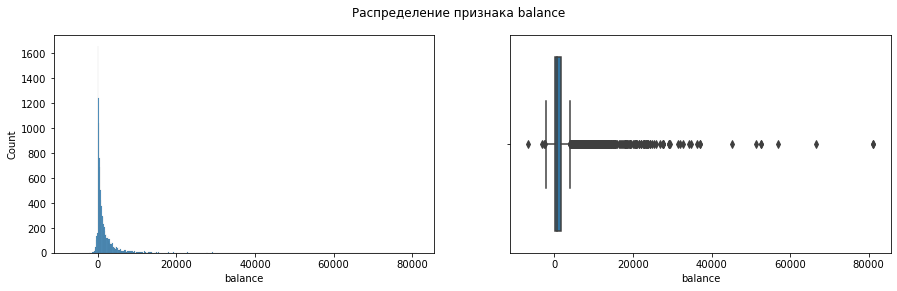

In [15]:
# удалите все выбросы для признака balance
# ваш код
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Распределение признака balance');
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);

In [16]:
def outliers_iqr(data, feature, log_scale=False, left=1.5, right=1.5):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound)|(x > upper_bound)]
    cleaned = data[(x >= lower_bound)&(x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

In [17]:
outliers, df_cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Нижняя граница: {round(lower_bound)}\nВерхняя граница: {round(upper_bound)}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_cleaned.shape[0]}')

Нижняя граница: -2241
Верхняя граница: 4063
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


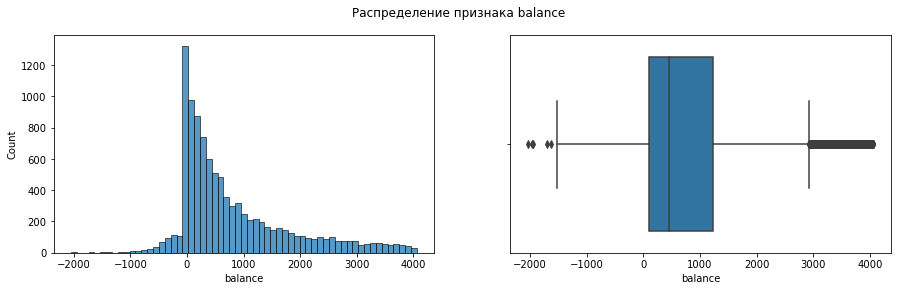

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Распределение признака balance');
histplot = sns.histplot(data=df_cleaned, x='balance', ax=axes[0]);
boxplot = sns.boxplot(data=df_cleaned, x='balance', ax=axes[1]);

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

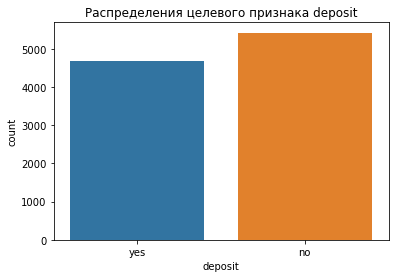

In [19]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(df_cleaned['deposit'].value_counts())
countplot = sns.countplot(data=df_cleaned, x='deposit');
countplot.set_title('Распределения целевого признака deposit');

### Задание 2

In [20]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
col_num = [col for col in df_cleaned.columns.tolist() if df_cleaned[col].dtype not in ['object']]
col_num

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [21]:
df_cleaned[col_num].describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


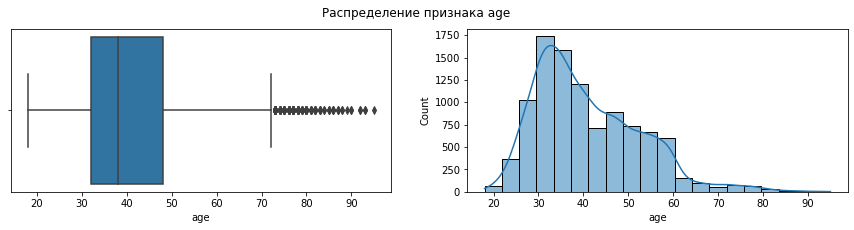

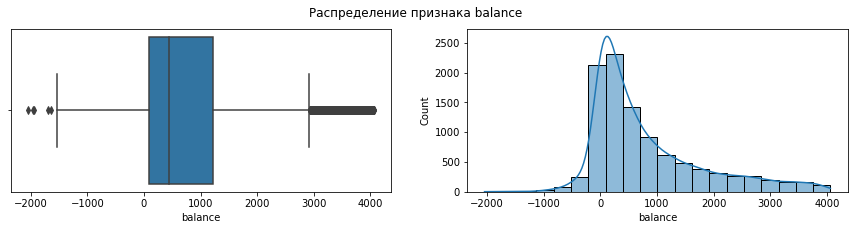

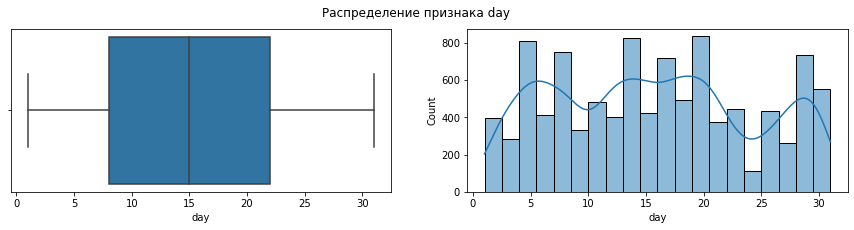

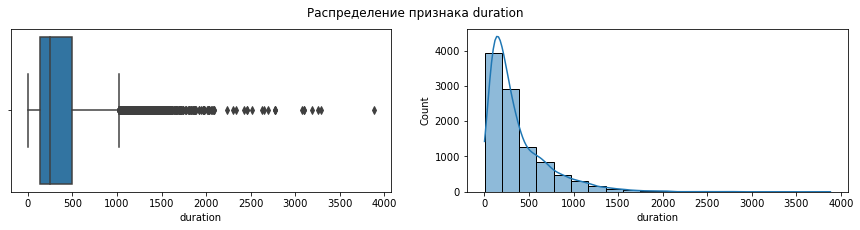

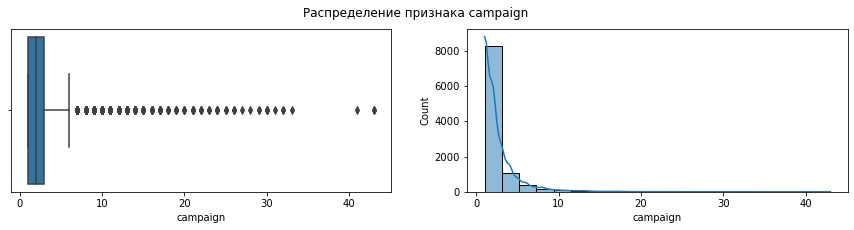

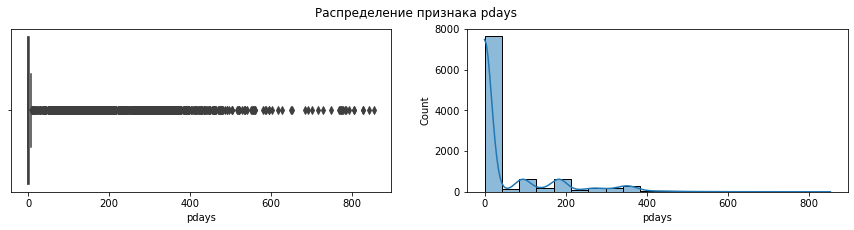

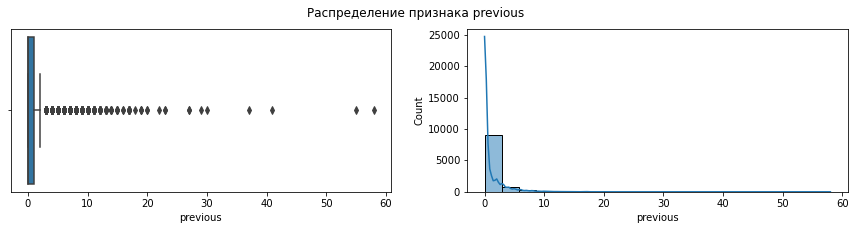

In [22]:
for col in col_num:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    fig.suptitle(f'Распределение признака {col}')
    boxplot = sns.boxplot(
        data=df_cleaned,
        x=col,
        orient='h',
        width=0.9,
        ax=ax[0]
    )
    sns.histplot(
        data=df_cleaned,
        x=col,
        bins=20,
        kde=True,
    );

#### Анализ

*age* - распределен нормально, большая часть клиентов от 32 до 48 лет.   
*balance* - основные клиенты с депозитом до 1000$    
*duration (продолжительность контакта в секундах)* - есть кнтакты менее 5 сек, которые говорят, что клиент не стал слушать предложения банка    
*campaign (количество контактов с этим клиентом в течение текущей кампании)* - 75 квантиль = 3 контактом что является адекватным числом контактов с одним клиентом за период компаниие, все что больше можно рассматривать как анамалии или неадекватность выстраивание компании.    
*pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании)* - есть клиенты с которыми не было не одного контакта в течение года    
*previous (количество контактов до текущей кампании)* - присутствие явных аномалий более 10 контактов необходимо смотреть

### Задание 3

In [23]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

In [24]:
col_cat = [col for col in df_cleaned.columns.tolist() if df_cleaned[col].dtype in ['object']]
df_cleaned[col_cat].describe()

,deposit,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,2,11,3,3,2,2,2,3,12,4
top,no,management,married,secondary,no,no,no,cellular,may,unknown
freq,5424,2315,5715,5517,9939,5243,8712,7283,2617,7570


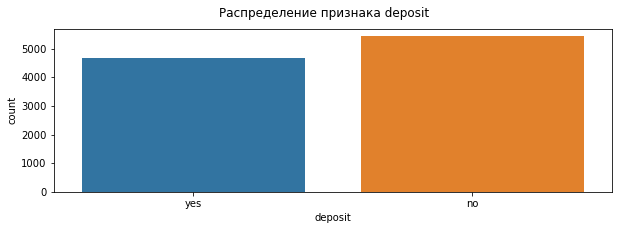

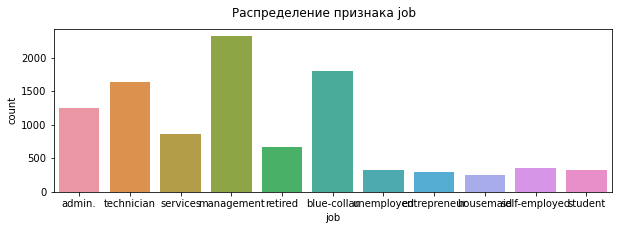

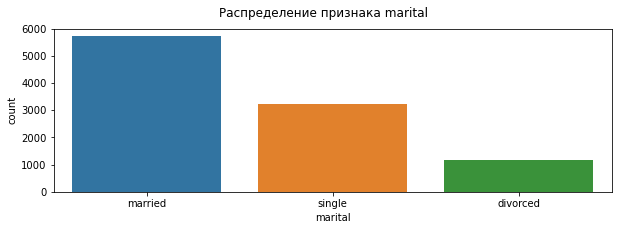

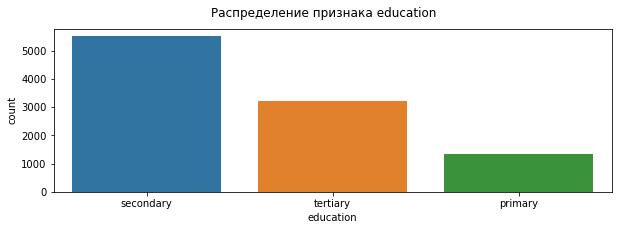

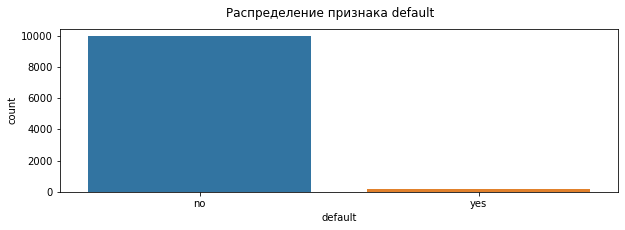

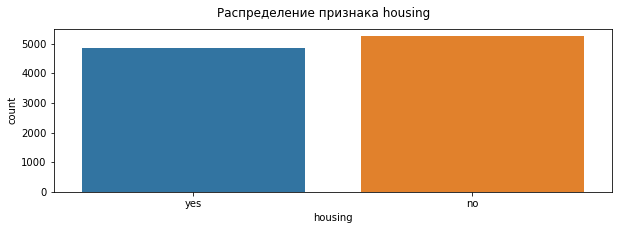

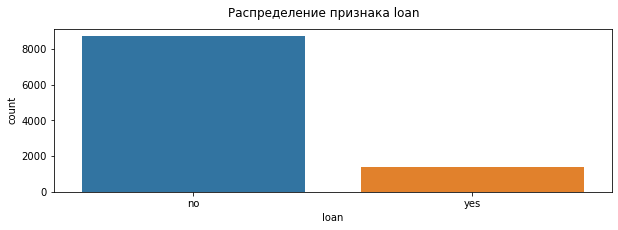

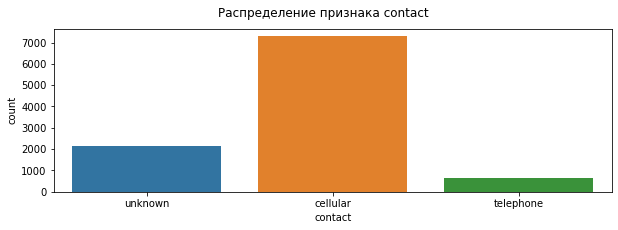

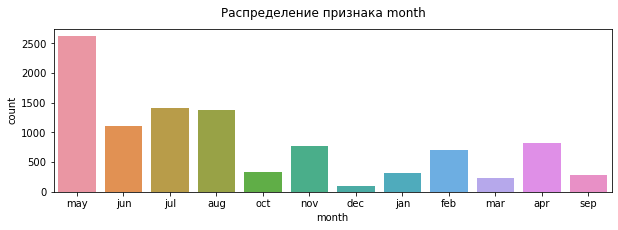

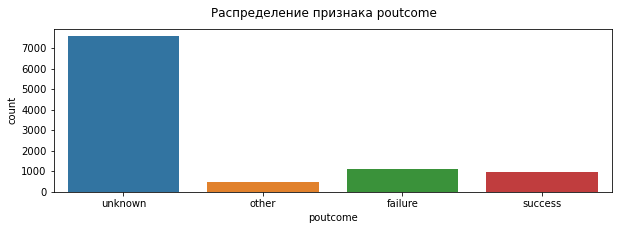

In [25]:
for col in col_cat:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
    fig.suptitle(f'Распределение признака {col}')
    # display(df_cleaned[col].value_counts())
    sns.countplot(data=df_cleaned, x=col);

### Задание 4

In [26]:
col_cat

['deposit',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

<AxesSubplot:xlabel='poutcome'>

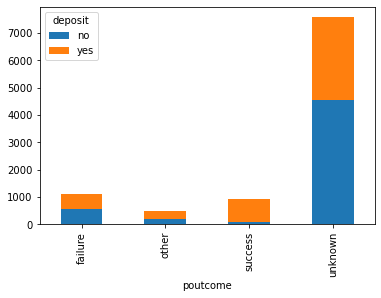

In [27]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
types = df_cleaned.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 5

In [28]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
months = df_cleaned.groupby("month")['deposit'].value_counts(
    normalize=False).unstack().reset_index().rename(columns={'no': 'no_deposit',
                                                              'yes': 'yes_deposit',
                                                             })
months['failure'] = round(months['no_deposit'] / (months['no_deposit'] + months['yes_deposit']), 2)

In [29]:
months

deposit,month,no_deposit,yes_deposit,failure
0,apr,317,513,0.38
1,aug,775,610,0.56
2,dec,9,84,0.10
3,feb,323,386,0.46
4,jan,194,125,0.61
5,jul,836,582,0.59
6,jun,606,498,0.55
7,mar,24,213,0.10
8,may,1776,841,0.68
9,nov,456,324,0.58


#### Задание 6

In [30]:
def get_age_group(arg):
    if arg < 30:
        return '<30'
    elif 30 <= arg < 40:
        return '30-39'
    elif 40 <= arg < 50:
        return '40-49'
    elif 50 <= arg < 60:
        return '50-59'
    else:
        return '60+'

In [31]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df_cleaned['age_group'] = df_cleaned['age'].apply(get_age_group)

Text(0.5, 0.98, 'Распределение открытия депозита по возрастам')

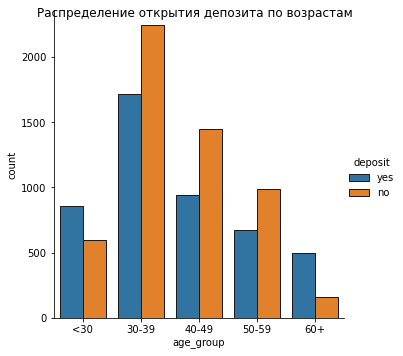

In [32]:
catplot = sns.catplot(
    x="age_group", 
    hue="deposit", 
    kind="count",
    edgecolor=".1", 
    order=['<30', '30-39', '40-49', '50-59', '60+'],
    data=df_cleaned
)
catplot.fig.suptitle('Распределение открытия депозита по возрастам')

### Задание 7

In [33]:
df_cleaned.head()

,deposit,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,age_group
0,yes,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,50-59
1,yes,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,50-59
2,yes,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,40-49
3,yes,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,50-59
4,yes,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,50-59


Text(0.5, 0.98, 'Распределение открытия депозита в зависимости от семейного статусa')

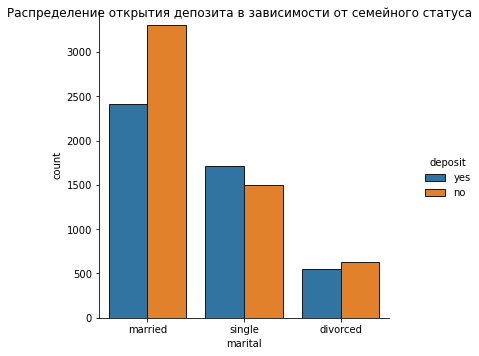

In [34]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статусаa
catplot = sns.catplot(
    x="marital", 
    hue="deposit", 
    kind="count",
    edgecolor=".1", 
    data=df_cleaned
)
catplot.fig.suptitle('Распределение открытия депозита в зависимости от семейного статусa')

Text(0.5, 0.98, 'Распределение открытия депозита в зависимости от образования')

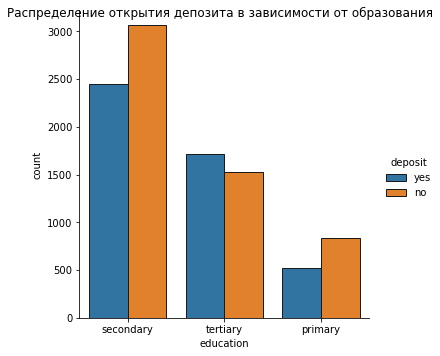

In [35]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
catplot = sns.catplot(
    x="education", 
    hue="deposit", 
    kind="count",
    edgecolor=".1", 
    data=df_cleaned
)
catplot.fig.suptitle('Распределение открытия депозита в зависимости от образования')

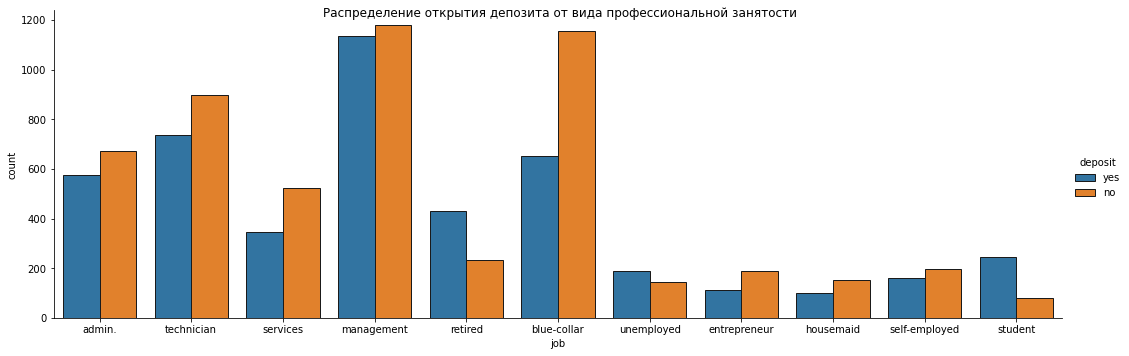

In [36]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
# fig, axes = plt.subplots(figsize=(15, 4))
catplot = sns.catplot(
    data=df_cleaned,
    x="job", 
    hue="deposit", 
    kind="count",
    height=5,
    aspect=3,
    edgecolor=".1", 
    ax=axes,
)
catplot.fig.suptitle('Распределение открытия депозита от вида профессиональной занятости');

### Задание 8

In [37]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
yes_deposit = df_cleaned[df_cleaned['deposit'] == 'yes']

In [38]:
yes_deposit.groupby(['education','marital'])['deposit'].value_counts(
    normalize=False).unstack().reset_index()

deposit,education,marital,yes
0,primary,divorced,96
1,primary,married,339
2,primary,single,82
3,secondary,divorced,283
4,secondary,married,1289
5,secondary,single,879
6,tertiary,divorced,174
7,tertiary,married,784
8,tertiary,single,755


## Часть 3: преобразование данных

### Задание 1

In [39]:
# преобразуйте уровни образования
le = preprocessing.LabelEncoder()
le.fit(df_cleaned['education'])
df_cleaned['education_cod'] = le.transform(df_cleaned['education'])

In [40]:
sum(df_cleaned['education_cod'])

11995

In [42]:
le.fit(df_cleaned['age_group'])
df_cleaned['age_group_cod'] = le.transform(df_cleaned['age_group'])

### Задание 2(Задание 4.3)

Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя

In [43]:
# преобразуйте бинарные переменные в представление из нулей и единиц
lb = preprocessing.LabelBinarizer()
lb.fit(df_cleaned['deposit'])
df_cleaned['deposit'] = lb.transform(df_cleaned['deposit'])

In [44]:
round(df_cleaned['deposit'].std(), 3)

0.499

In [45]:
lb.fit(df_cleaned['default'])
df_cleaned['default_cod'] = lb.transform(df_cleaned['default'])

In [46]:
lb.fit(df_cleaned['housing'])
df_cleaned['housing_cod'] = lb.transform(df_cleaned['housing'])

In [47]:
lb.fit(df_cleaned['loan'])
df_cleaned['loan_cod'] = lb.transform(df_cleaned['loan'])

__Не правильный ответ__

In [51]:
round(((df_cleaned['default_cod']+df_cleaned['housing_cod']+df_cleaned['loan_cod']).mean()),3)

0.635

In [55]:
df_cleaned.shape

(10105, 25)

In [58]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   deposit            10105 non-null  int64  
 1   age                10105 non-null  int64  
 2   job                10105 non-null  object 
 3   marital            10105 non-null  object 
 4   education          10105 non-null  object 
 5   default            10105 non-null  object 
 6   balance            10105 non-null  float64
 7   housing            10105 non-null  object 
 8   loan               10105 non-null  object 
 9   day                10105 non-null  int64  
 10  month              10105 non-null  object 
 11  duration           10105 non-null  int64  
 12  campaign           10105 non-null  int64  
 13  pdays              10105 non-null  int64  
 14  previous           10105 non-null  int64  
 15  poutcome           10105 non-null  object 
 16  age_group          101

### Задание 3

In [54]:
df_cleaned = pd.get_dummies(
    df_cleaned, 
    columns=['contact'], 
    prefix_sep="_"
)

In [59]:
# создайте дамми-переменные
df_cleaned = pd.get_dummies(
    df_cleaned, 
    columns=['job', 'marital', 'month', 'poutcome'], 
    prefix_sep="_"
)

In [60]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   deposit            10105 non-null  int64  
 1   age                10105 non-null  int64  
 2   education          10105 non-null  object 
 3   default            10105 non-null  object 
 4   balance            10105 non-null  float64
 5   housing            10105 non-null  object 
 6   loan               10105 non-null  object 
 7   day                10105 non-null  int64  
 8   duration           10105 non-null  int64  
 9   campaign           10105 non-null  int64  
 10  pdays              10105 non-null  int64  
 11  previous           10105 non-null  int64  
 12  age_group          10105 non-null  object 
 13  education_cod      10105 non-null  int64  
 14  age_group_cod      10105 non-null  int64  
 15  default_cod        10105 non-null  int64  
 16  housing_cod        101

### Задание 4

<AxesSubplot:>

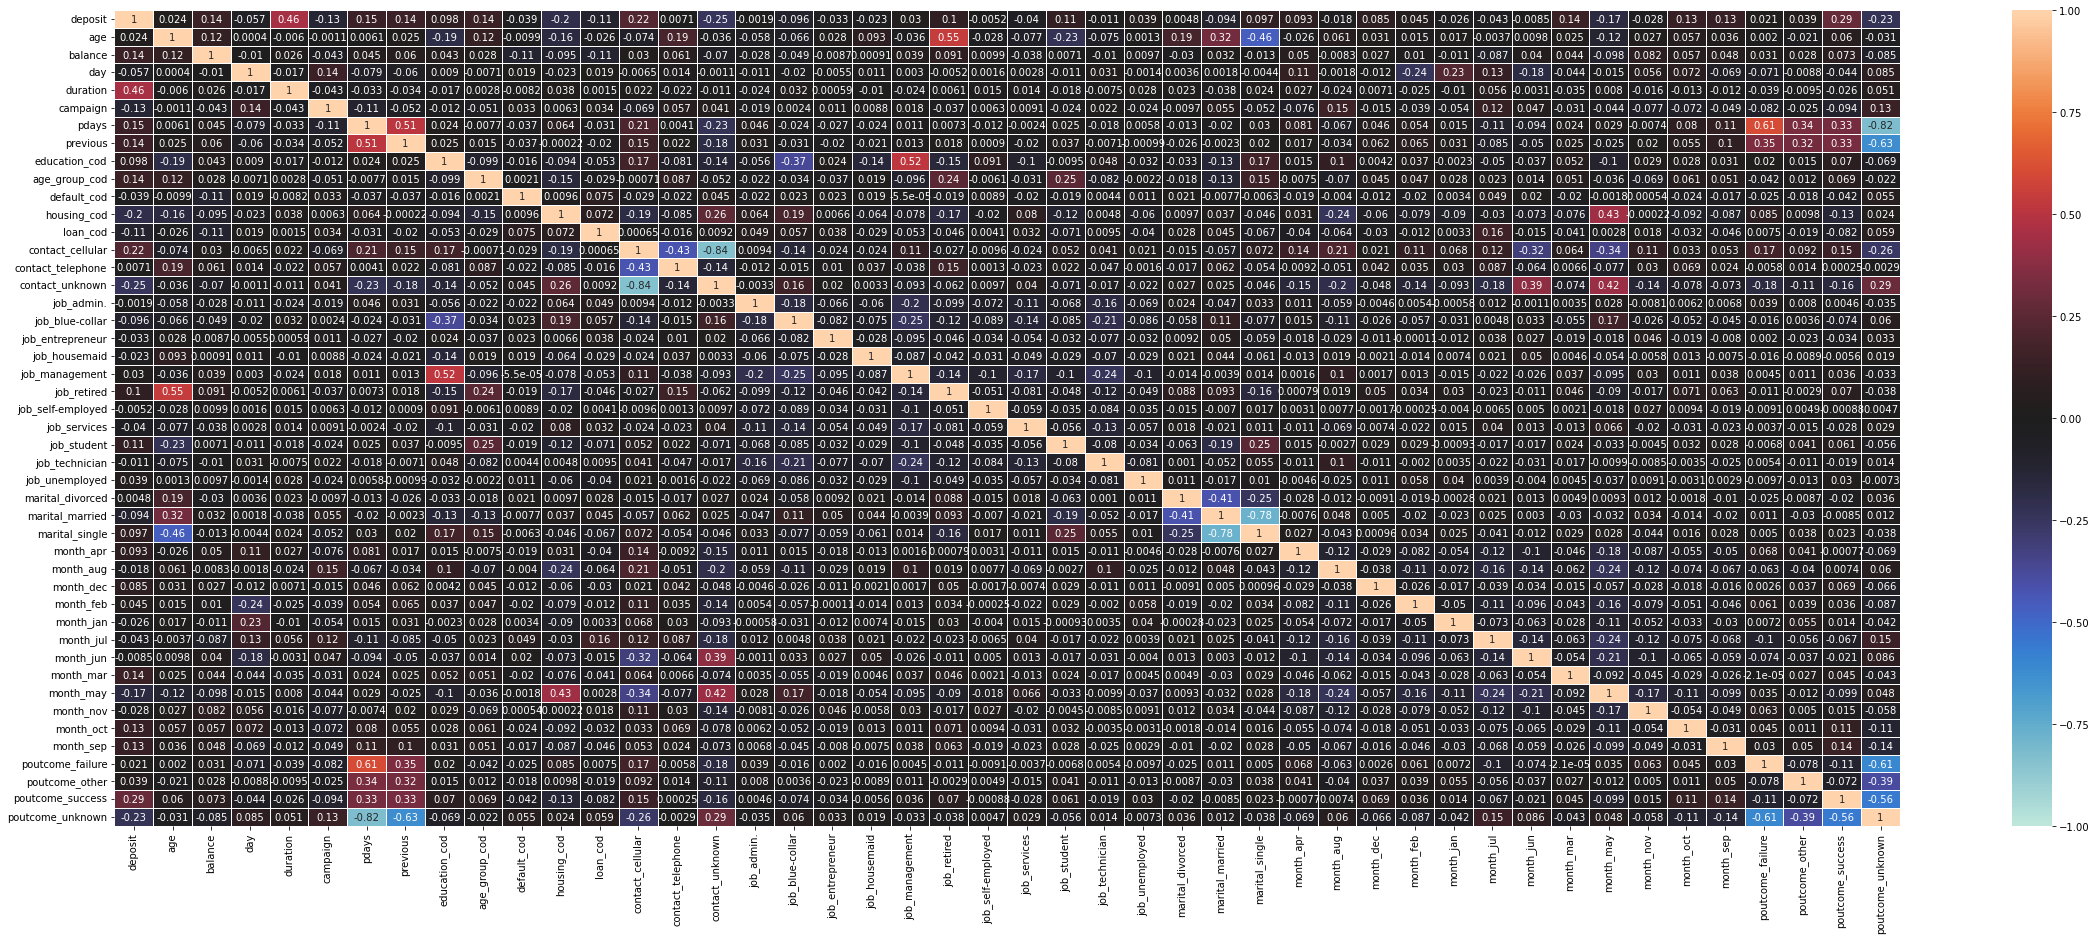

In [62]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (40,15))
sns.heatmap(df_cleaned.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, linewidths=.5)

### Задание 5

In [93]:
X = df_cleaned.drop(['deposit'], axis=1)
y = df_cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [94]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 50)

In [95]:
round(y_test.mean(), 2)

0.46

### Задание 6

In [96]:
X_train.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
7287,34,tertiary,no,557.0,yes,no,16,513,1,-1,...,0,0,0,0,0,0,0,0,0,1
4766,34,tertiary,no,69.0,no,yes,25,296,1,205,...,0,0,0,1,0,0,1,0,0,0
5712,33,tertiary,no,0.0,yes,no,5,399,2,358,...,0,0,1,0,0,0,0,1,0,0
2530,37,secondary,no,444.0,no,no,14,137,1,102,...,0,0,0,0,0,0,0,0,1,0
9294,39,secondary,no,1444.0,no,no,19,100,1,117,...,0,0,0,1,0,0,0,0,1,0


In [97]:
col_cat = [col for col in X_train.columns.tolist() if X_train[col].dtype in ['object']]

In [98]:
col_cat

['education', 'default', 'housing', 'loan', 'age_group']

In [99]:
X_train.drop(['education', 'default', 'housing', 'loan', 'age_group'], axis=1, inplace=True)
X_train.shape

(6770, 45)

In [100]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
X_new = selector.fit_transform(X_train, y_train)
X_new.shape

(6770, 15)

In [101]:
X_train.columns[selector.get_support(indices=True)]
columns_list = X_train.columns[selector.get_support(indices=True)].tolist()
X_new = pd.DataFrame(X_new, columns=columns_list)

In [102]:
columns_list

['balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group_cod',
 'housing_cod',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 7 (Задание 4.10)

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. Ответ округлите до двух знаков после точки-разделителя

In [103]:
mm_scaler = preprocessing.MinMaxScaler()

In [104]:
col_names_train = list(X_train.columns)
mm_scaler.fit(X_train)
X_train_scaled = pd.DataFrame(mm_scaler.transform(X_train), columns=col_names_train)

In [105]:
X_train_scaled.head(1)

,age,balance,day,duration,campaign,pdays,previous,education_cod,age_group_cod,default_cod,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.213333,0.426374,0.5,0.131735,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [106]:
X_test.drop(['education', 'default', 'housing', 'loan', 'age_group'], axis=1, inplace=True)

In [107]:
col_names_test = list(X_test.columns)
mm_scaler.fit(X_test)
X_test_scaled = pd.DataFrame(mm_scaler.transform(X_test), columns=col_names_test)
X_test_scaled.head(1)

,age,balance,day,duration,campaign,pdays,previous,education_cod,age_group_cod,default_cod,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.805195,0.349484,0.366667,0.09285,0.0,0.11339,0.036364,0.0,0.75,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


__Не правильный ответ__

In [108]:
print(round(X_test_scaled['age'].mean(), 2))

0.3


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задание 2

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 3

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [4]:
# обучите на ваших данных случайный лес

### Задание 2

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание3

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 4

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задание 5

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna